## Подготовка

In [75]:
import pandas as pd 
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
import time
import os
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

In [76]:
pth1 = 'taxi.csv'
pth2 = '/datasets/taxi.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1, parse_dates=[0], index_col=[0])
    display(df.head())
    print(df.info())
elif os.path.exists(pth2):
    df = pd.read_csv(pth2, parse_dates=[0], index_col=[0])
    display(df.head())
    print(df.info())
else:
    print('Something is wrong') 

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


## Анализ

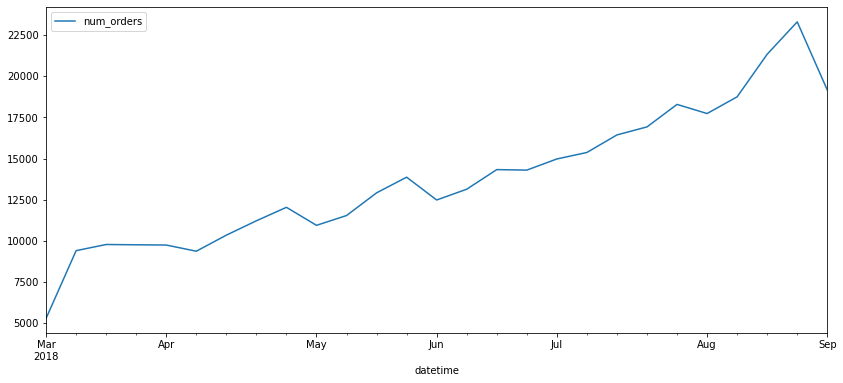

In [77]:
dfw=df.resample('1W').sum()
dfw.plot(figsize = (14,6))
plt.show()

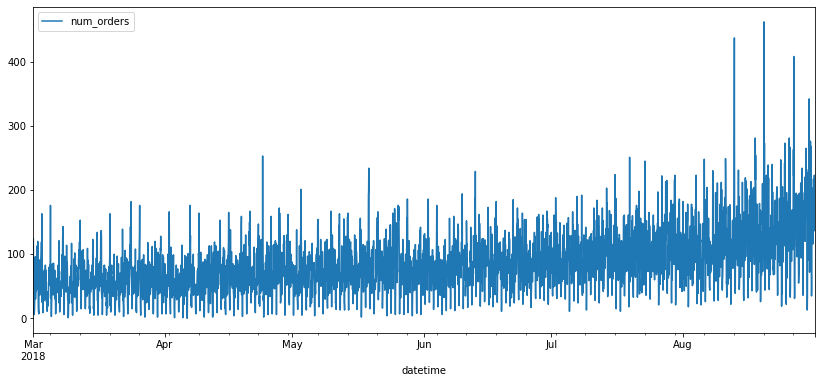

In [78]:
df=df.resample('1H').sum()
df.plot(figsize = (14,6))
plt.show()

Ничего не понятно. Исследуем дальше

In [79]:
decomposed = seasonal_decompose(df)

Text(0.5, 1.0, 'Residuals')

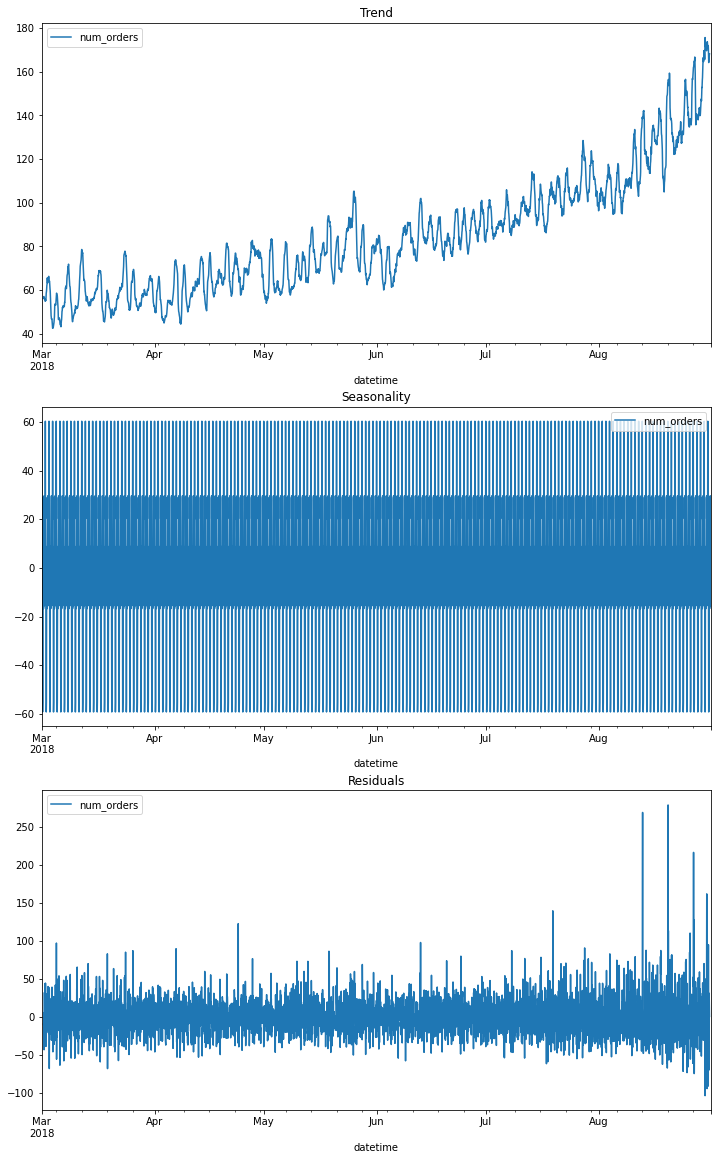

In [80]:
plt.figure(figsize=(12, 20))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')

И тут ничего не видно. Возьмем меньше данных

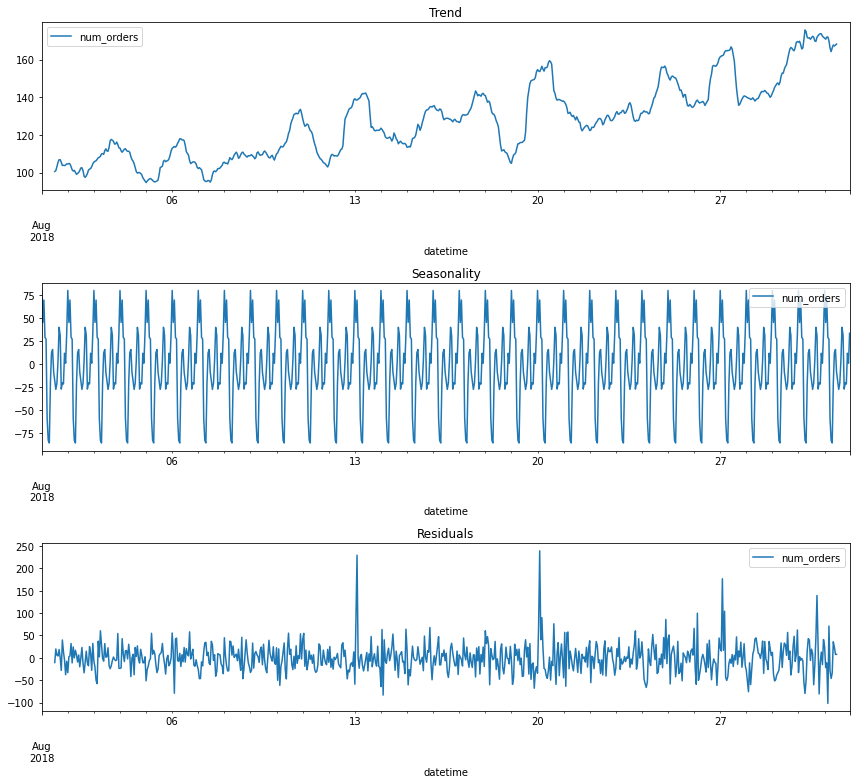

In [81]:
decomposed = seasonal_decompose(df['2018-08-01':'2018-08-31'])
plt.figure(figsize=(12, 11))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

А вот тут уже становится понятнее. Мы видим сезонность. Ночью меньше людей заказывает таксиЮ чем вечером. Ряд стационарен. 

Так же, на остатках видим стационарность. Это можно прогнозировать.

## Обучение

Константая модель, которая прогнозирует предыдущее значение

In [82]:
train, test = train_test_split(dfh, shuffle=False, test_size=0.1)
pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]
print("RMSE:", mean_squared_error(test,pred_previous)**0.5)

RMSE: 58.856486242815066


Константая модель, которая прогнозирует среднее значение

In [83]:
pred_median = np.ones(test.shape)*train['num_orders'].mean()
print("RMSE константной модели:", mean_squared_error(test,pred_median)**0.5)

RMSE константной модели: 84.74414402014742


Напишем функцию для создания признаков

In [84]:
def make_features(data, max_lag, rolling_mean_size):
    df['year'] = data.index.year
    df['month'] = data.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    for lag in range(1, max_lag+1):
        df['lag_{}'.format(lag)]= df['num_orders'].shift(lag)
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    return df

**LinearRegression**

In [85]:
%%time
best_lag=0
best_rolling_size = 0
best_rmse=48
for lag in range (1, 100, 10):
    for roll in range(1,100,10):
        
        df_new =make_features(df, lag, roll)
        train, test=train_test_split(df_new, shuffle=False, test_size=0.1)
        train=train.dropna()
        features_train = train.drop(['num_orders'], axis=1)
        target_train = train['num_orders']
        features_test = test.drop(['num_orders'], axis=1)
        target_test =test['num_orders']
        
        regress = LinearRegression()
        regress_params={'normalize':[True,False]}
        tss = TimeSeriesSplit(n_splits = 5)
        grid= GridSearchCV(regress, regress_params, scoring='neg_mean_squared_error',  cv=tss , n_jobs = -1)
        grid.fit(features_train, target_train)
        rmse=(-grid.best_score_)**0.5   
        if rmse < best_rmse:
            best_rmse=rmse
            best_lag=lag
            best_rolling_size = roll
        
            
print('RMSE на кроссвалидации: {:.2f}:'.format(best_rmse))
print('Размер смещения: {:.2f}:'.format(best_lag))
print('Размер скользящего окна: {:.2f} '.format(best_rolling_size))
print('Наилучшие параметры для модели:', grid.best_params_)

C:\Users\EGO\anaconda3\envs\praktikum_env_win_new\lib\site-packages\sklearn\model_selection\_search.py:793: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
C:\Users\EGO\anaconda3\envs\praktikum_env_win_new\lib\site-packages\sklearn\model_selection\_search.py:793: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If

RMSE на кроссвалидации: 26.69:
Размер смещения: 41.00:
Размер скользящего окна: 61.00 
Наилучшие параметры для модели: {'normalize': False}
Wall time: 15.4 s


**RandomForest**

In [86]:
%%time
best_lag=0
best_rolling_size = 0
best_rmse=48
for lag in range (1, 100, 10):
    for roll in range(1,100,10):
        df_new =make_features(df, lag, roll)
        train, test=train_test_split(df_new, shuffle=False, test_size=0.1)
        train=train.dropna()
        features_train = train.drop(['num_orders'], axis=1)
        target_train = train['num_orders']
        features_test = test.drop(['num_orders'], axis=1)
        target_test =test['num_orders']
        
        forest = RandomForestRegressor()
        forest_params={'max_depth': range(1, 21, 5)}
        tss = TimeSeriesSplit(n_splits = 5)
        grid= GridSearchCV(forest,forest_params, scoring='neg_mean_squared_error',  cv=tss , n_jobs = -1)
        grid.fit(features_train, target_train)
        rmse=(-grid.best_score_)**0.5 
        if rmse < best_rmse:
            best_rmse=rmse
            best_lag=lag
            best_rolling_size = roll
        
            
print('RMSE на кроссвалидации: {:.2f}:'.format(best_rmse))
print('Размер смещения: {:.2f}:'.format(best_lag))
print('Размер скользящего окна: {:.2f} '.format(best_rolling_size))
print('Наилучшие параметры для модели:', grid.best_params_)

C:\Users\EGO\anaconda3\envs\praktikum_env_win_new\lib\site-packages\sklearn\model_selection\_search.py:793: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
C:\Users\EGO\anaconda3\envs\praktikum_env_win_new\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\EGO\anaconda3\envs\praktikum_env_win_new\lib\site-packages\sklearn\utils\fixes.py:223: DeprecationWarning: distutils Ve

RMSE на кроссвалидации: 25.31:
Размер смещения: 91.00:
Размер скользящего окна: 81.00 
Наилучшие параметры для модели: {'max_depth': 11}
Wall time: 4min 11s


**CatBoost**

In [87]:
%%time
best_lag=0
best_rolling_size = 0
best_rmse=48
for lag in range (1, 101, 10):
    for roll in range(1,101,10):
        df_new =make_features(df, lag, roll)
        train, test=train_test_split(df_new, shuffle=False, test_size=0.1)
        train=train.dropna()
        features_train = train.drop(['num_orders'], axis=1)
        target_train = train['num_orders']
        features_test = test.drop(['num_orders'], axis=1)
        target_test =test['num_orders']
        
        cat = CatBoostRegressor(iterations=100, verbose=False)
        cat_params = {'learning_rate':[0.1, 0.3, 0.5, 0.7]}
        tss = TimeSeriesSplit(n_splits = 5)
        grid= GridSearchCV(cat, cat_params, scoring='neg_mean_squared_error',  cv=tss , n_jobs = -1)
        grid.fit(features_train, target_train)
        rmse=(-grid.best_score_)**0.5
        if rmse < best_rmse:
            best_rmse=rmse
            best_lag=lag
            best_rolling_size = roll
                
            
print('RMSE на кроссвалидации: {:.2f}:'.format(best_rmse))
print('Размер смещения: {:.2f}:'.format(best_lag))
print('Размер скользящего окна: {:.2f} '.format(best_rolling_size))
print('Наилучшие параметры для модели:', grid.best_params_)

C:\Users\EGO\anaconda3\envs\praktikum_env_win_new\lib\site-packages\sklearn\model_selection\_search.py:793: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
C:\Users\EGO\anaconda3\envs\praktikum_env_win_new\lib\site-packages\sklearn\model_selection\_search.py:793: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If

RMSE на кроссвалидации: 24.29:
Размер смещения: 1.00:
Размер скользящего окна: 21.00 
Наилучшие параметры для модели: {'learning_rate': 0.1}
Wall time: 10min 1s


## Тестирование

RMSE тестовой выборки: 40.46


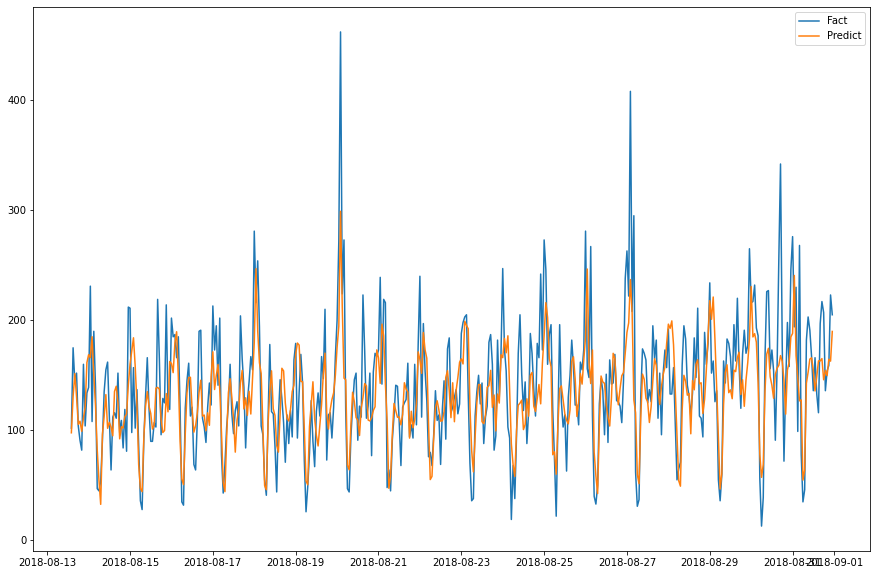

In [99]:
df_cat =make_features(df, 1, 21)
train, test=train_test_split(df_cat, shuffle=False, test_size=0.1)
train=train.dropna()
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test =test['num_orders']

cat = CatBoostRegressor(iterations=100, verbose=False, learning_rate=0.1, depth=3)
cat.fit(features_train, target_train)
test_pred= cat.predict(features_test)
rmse_test=(mean_squared_error(target_test,test_pred))**0.5 
print('RMSE тестовой выборки: {:.2f}'.format(rmse_test))

plt.figure(figsize=(15, 10))
plt.plot(features_test.index, target_test, label='Fact')
plt.plot(features_test.index, test_pred, label='Predict')
plt.legend()
plt.show()

## Вывод

Были взяты 3 модели для прогнозирования. Лучшей по результатам кросс-валидации оказалась CatBoost. Результаты на тестовой выборке - 40.46 RMSE